In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd 
import numpy as np
import os

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

In [3]:
dataset = keras.utils.get_file('aclImdb_v1',url,untar=True,cache_dir='.',cache_subdir='')

In [4]:
os.path.dirname(dataset)

'.'

In [5]:
dataset_dir = os.path.join(os.path.dirname(dataset),'aclImdb')

In [6]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [7]:
train_dir = os.path.join(dataset_dir,'train')
test_dir = os.path.join(dataset_dir,'test')

In [8]:
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [9]:
os.listdir(test_dir)

['labeledBow.feat', 'neg', 'pos', 'urls_neg.txt', 'urls_pos.txt']

In [10]:
import shutil

In [11]:
shutil.rmtree(os.path.join(train_dir,'unsup'))

In [12]:
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [13]:
raw_train_ds = keras.utils.text_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    batch_size=32,
    seed=42)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [14]:
raw_train_ds.class_names

['neg', 'pos']

In [15]:
raw_val_ds = keras.utils.text_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    batch_size=32,
    seed=42)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [16]:
raw_test_ds = keras.utils.text_dataset_from_directory(test_dir)

Found 25000 files belonging to 2 classes.


In [17]:
import re
import string

In [18]:
def cunstom_standardizer(input_data):
    lower_text = tf.strings.lower(input_data)
    html_striped = tf.strings.regex_replace(lower_text,'<br />',' ')
    return tf.strings.regex_replace(html_striped,f'[{re.escape(string.punctuation)}]','')

In [19]:
cunstom_standardizer('Heloo <br /> ??? my naem "" is (Adesh)')

<tf.Tensor: shape=(), dtype=string, numpy=b'heloo    my naem  is adesh'>

In [20]:
vectorization_layer = keras.layers.TextVectorization(
    max_tokens=1000,
    output_mode='int',
    output_sequence_length=250,
    standardize=cunstom_standardizer)

In [21]:
train_data = raw_train_ds.map(lambda x,y:x)

In [22]:
vectorization_layer.adapt(train_data)

In [23]:
review_batch,label_batch = next(iter(raw_train_ds))

In [24]:
review_batch[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just st

In [25]:
label_batch[0]

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In [26]:
vectorization_layer(tf.expand_dims(review_batch[0],-1))

<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  1, 313,   1, 313, 661,   7,   2,  52, 229,   5,   2, 200,   3,
         38, 170, 669,  29,   1,   6,   2,  83, 297, 549,  32, 410,   3,
          2, 186,  12,  29,   4,   1, 191, 510, 549,   6,   2,   1, 212,
         46, 576, 175, 168,  20,   1,   1, 290,   4,   1, 761, 969,   1,
          3,  24, 935,   1, 393,   7,   1,   1,   4,   1, 250, 148,   4,
        112, 436, 761,   1, 548,   4,   1,  31,   2,   1,  28,   1,   3,
          1,   9,   6, 163,   4,   1,  20,   2,   1,  15,  85,  53, 147,
          9, 292,  89, 959,   1, 984,  27, 762,   6, 959,   9, 564,  18,
          7,   1,  32,  24,   1,  36,   1,  85,   3,   1,  85,   6,   1,
          3,   1,   2,   1, 301, 965,   7,   4, 112, 740,   1,  12,   1,
          1,   1,   3,   4, 428,   3,   1,   6, 512,   1,   1, 278,  27,
        139,  25, 308,   1, 579,   5, 259,   1,   7,  92,   1,  32,   2,
          1, 230,  27, 289,   9,  35,   2,   1,  18,  27, 144,   1,  56,
   

In [27]:
def vectorized_text(text,label):
    text = tf.expand_dims(text,-1)
    return vectorization_layer(text),label

In [28]:
train_ds = raw_train_ds.map(vectorized_text)
val_ds = raw_val_ds.map(vectorized_text)
test_ds = raw_test_ds.map(vectorized_text)

In [29]:
next(iter(train_ds))

(<tf.Tensor: shape=(32, 250), dtype=int64, numpy=
 array([[ 86,  17, 260, ...,   0,   0,   0],
        [ 10, 237,   1, ...,   0,   0,   0],
        [ 48,   4,   1, ...,   0,   0,   0],
        ...,
        [462,   2,   1, ...,   0,   0,   0],
        [ 48,   1, 120, ..., 477, 300,  14],
        [ 29,   4,  52, ...,   0,   0,   0]], dtype=int64)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 0, 0, 0, 1, 1, 0, 1])>)

In [30]:
vectorization_layer.get_vocabulary()[866]

'begin'

In [31]:
model = keras.models.Sequential(
    [
        keras.layers.Embedding(1001,16),
        keras.layers.Dropout(0.5),
        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1)
    ])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          16016     
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 16,033
Trainable params: 16,033
Non-trainable params: 0
____________________________________________________

In [33]:
model.compile(
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=keras.metrics.BinaryAccuracy(threshold = 0.0))

In [34]:
model_h = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10)

Epoch 1/10
625/625 [==============================] - 84s 133ms/step - loss: 0.6797 - binary_accuracy: 0.6309 - val_loss: 0.6551 - val_binary_accuracy: 0.7066
Epoch 2/10
625/625 [==============================] - 36s 56ms/step - loss: 0.6172 - binary_accuracy: 0.7316 - val_loss: 0.5803 - val_binary_accuracy: 0.7582
Epoch 3/10
625/625 [==============================] - 12s 20ms/step - loss: 0.5475 - binary_accuracy: 0.7758 - val_loss: 0.5165 - val_binary_accuracy: 0.7984
Epoch 4/10
625/625 [==============================] - 13s 20ms/step - loss: 0.4921 - binary_accuracy: 0.8026 - val_loss: 0.4694 - val_binary_accuracy: 0.8108
Epoch 5/10
625/625 [==============================] - 14s 22ms/step - loss: 0.4566 - binary_accuracy: 0.8168 - val_loss: 0.4377 - val_binary_accuracy: 0.8228
Epoch 6/10
625/625 [==============================] - 14s 22ms/step - loss: 0.4304 - binary_accuracy: 0.8235 - val_loss: 0.4169 - val_binary_accuracy: 0.8304
Epoch 7/10
625/625 [==============================]

In [35]:
model.evaluate(test_ds)

782/782 [==============================] - 86s 109ms/step - loss: 0.3740 - binary_accuracy: 0.8423


[0.373954176902771, 0.8422799706459045]

In [36]:
loss, binary_accuracy, val_loss, val_binary_accuracy = model_h.history.values()

In [37]:
import matplotlib.pyplot as plt

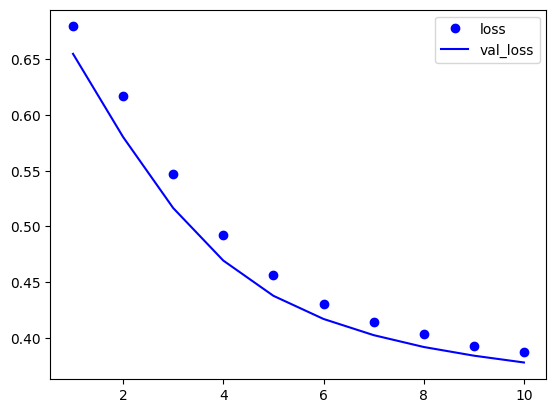

In [38]:
plt.plot(range(1,len(loss)+1),loss,'bo',label = 'loss')
plt.plot(range(1,len(loss)+1),val_loss,'b',label = 'val_loss')
plt.legend()
plt.show()

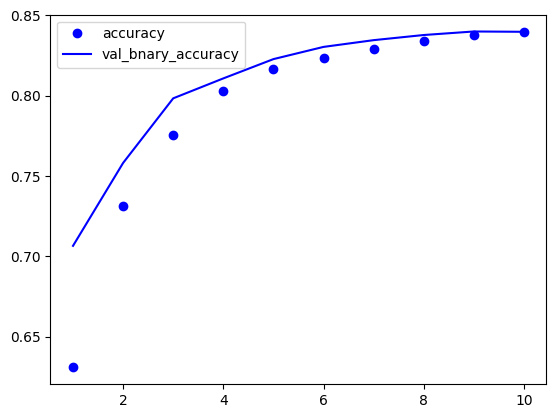

In [39]:
plt.plot(range(1,len(loss)+1),binary_accuracy,'bo',label = 'accuracy')
plt.plot(range(1,len(loss)+1),val_binary_accuracy,'b',label = 'val_bnary_accuracy')
plt.legend()
plt.show()

In [40]:
model_final = keras.models.Sequential([
    vectorization_layer,
    model,
    keras.layers.Activation('sigmoid')
])

In [41]:
model_final.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],
    optimizer='adam'
)

In [42]:
model_final_h = model_final.fit(raw_train_ds,validation_data=raw_val_ds,epochs=10)

Epoch 1/10
625/625 [==============================] - 43s 65ms/step - loss: 0.3801 - accuracy: 0.8418 - val_loss: 0.3733 - val_accuracy: 0.8410
Epoch 2/10
625/625 [==============================] - 15s 24ms/step - loss: 0.3741 - accuracy: 0.8459 - val_loss: 0.3694 - val_accuracy: 0.8416
Epoch 3/10
625/625 [==============================] - 15s 23ms/step - loss: 0.3701 - accuracy: 0.8443 - val_loss: 0.3670 - val_accuracy: 0.8430
Epoch 4/10
625/625 [==============================] - 15s 23ms/step - loss: 0.3672 - accuracy: 0.8451 - val_loss: 0.3648 - val_accuracy: 0.8426
Epoch 5/10
625/625 [==============================] - 17s 26ms/step - loss: 0.3652 - accuracy: 0.8483 - val_loss: 0.3625 - val_accuracy: 0.8422
Epoch 6/10
625/625 [==============================] - 15s 24ms/step - loss: 0.3620 - accuracy: 0.8500 - val_loss: 0.3602 - val_accuracy: 0.8438
Epoch 7/10
625/625 [==============================] - 15s 24ms/step - loss: 0.3613 - accuracy: 0.8472 - val_loss: 0.3601 - val_accuracy:

In [43]:
model_final_h.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [44]:
f_loss, f_accuracy, f_val_loss, f_val_accuracy = model_final_h.history.values()

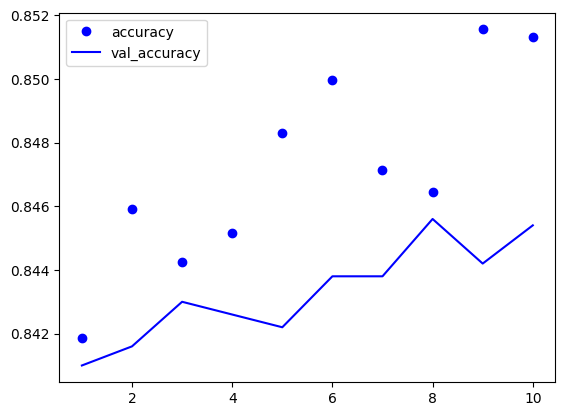

In [45]:
plt.plot(range(1,len(f_loss)+1),f_accuracy,'bo',label = 'accuracy')
plt.plot(range(1,len(loss)+1),f_val_accuracy,'b',label = 'val_accuracy')
plt.legend()
plt.show()

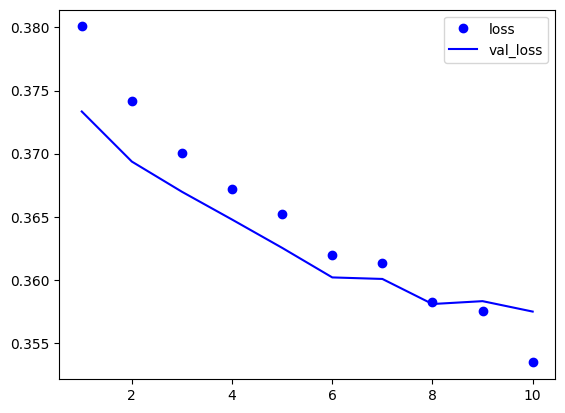

In [46]:
plt.plot(range(1,len(f_loss)+1),f_loss,'bo',label = 'loss')
plt.plot(range(1,len(loss)+1),f_val_loss,'b',label = 'val_loss')
plt.legend()
plt.show()

In [48]:
model_final.predict(raw_test_ds)

782/782 [==============================] - 69s 87ms/step


array([[0.00161581],
       [0.03524538],
       [0.08911232],
       ...,
       [0.81946146],
       [0.6609948 ],
       [0.99016935]], dtype=float32)

In [49]:
model_final.evaluate(raw_test_ds)

782/782 [==============================] - 12s 15ms/step - loss: 0.3512 - accuracy: 0.8490


[0.3512180745601654, 0.8489599823951721]

In [51]:
model_final.save('Text_Classifier_Model/model')

INFO:tensorflow:Assets written to: Text_Classifier_Model/model\assets


INFO:tensorflow:Assets written to: Text_Classifier_Model/model\assets
